# TRANSIT LIGHT CURVE FITTING with BATMAN and LMFIT
Thanks to Laura Kreidberg for the development of BATMAN (cite: Kriedberg (2015), PASP) and the excellent documentation maintained here:  http://astro.uchicago.edu/~kreidberg/batman/index.html

LMFIT (Non-Linear Least-Square Minimization and Curve-Fitting for Python, cite: Newville et al, 2014, 10.5281/zenodo.11813) documentation is maintained here: http://cars9.uchicago.edu/software/python/lmfit/index.html

This notebook will walk you through the process of fitting wavelength dependent transits to produce a planetary atmospheric spectrum.  This exercise was compiled by Kevin Stevenson (STScI) with substantial inputs from Nikole Lewis (STScI), Jonathan Fraine (STScI), and Laura Kreidberg (Harvard).

You may need to install/upgrade some packages:
1. BATMAN: pip install batman-package
2. LMFIT:  pip install lmfit
3. SciPy:  pip install scipy --upgrade  **OR**  easy_install --upgrade scipy
4. NumPy:  pip install numpy --upgrade  **OR**  easy_install --upgrade numpy

In [1]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import batman
import lmfit
%matplotlib inline

#### In the next cell we define a wrapper function to assist with our fitting and allow us to interface with BATMAN and LMFIT.

In [2]:
def batman_wrapper_lmfit(period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2, 
                         offset, slope, curvature,
                         times, ldtype='quadratic', transitType='primary'):
    '''
    Written By Jonathan Fraine
    https://github.com/exowanderer/Fitting-Exoplanet-Transits
    '''
    bm_params           = batman.TransitParams() # object to store transit parameters
    bm_params.per       = period   # orbital period
    bm_params.t0        = tcenter  # time of inferior conjunction
    bm_params.inc       = inc      # inclunaition in degrees
    bm_params.a         = aprs     # semi-major axis (in units of stellar radii)
    bm_params.rp        = rprs     # planet radius (in units of stellar radii)
    bm_params.ecc       = ecc      # eccentricity
    bm_params.w         = omega    # longitude of periastron (in degrees)
    bm_params.limb_dark = ldtype   # limb darkening model 
    bm_params.u         = [u1, u2] # limb darkening coefficients 

    m_eclipse = batman.TransitModel(bm_params, times, transittype=transitType)# initializes model

    # OoT == Out of transit    
    OoT_curvature = offset + slope*(times-times.mean()) + curvature*(times-times.mean())**2
    
    return m_eclipse.light_curve(bm_params) * OoT_curvature

In [3]:
# Set initial parameters using an ordered dictionary of Parameter objects
initialParams = lmfit.Parameters()
# Format: (key, value, vary?, min, max)
initialParams.add_many(                     # WASP-107b paramters from Anderson et al (2017)
    ('rprs' , 0.147, True, 0.0, 0.2),
    ('period' , 5.721490, False),
    ('tcenter' , 0., True, -0.1, 0.1),
    ('inc' , 89.7, True, 80., 90.),
    ('aprs' , 18.2, True, 15., 20.),
    ('ecc' , 0., False),
    ('omega' , 90., False),
    ('u1' , 0.284, True, 0., 1.),
    ('u2' , 0.208, True, 0., 1.),
    ('offset', 1.0, True, 0.0),
    ('slope', 0.0, False),
    ('curvature', 0.0, False))
# Show the results
initialParams

Parameters([('rprs', <Parameter 'rprs', 0.147, bounds=[0.0:0.2]>),
            ('period',
             <Parameter 'period', value=5.72149 (fixed), bounds=[-inf:inf]>),
            ('tcenter', <Parameter 'tcenter', 0.0, bounds=[-0.1:0.1]>),
            ('inc', <Parameter 'inc', 89.7, bounds=[80.0:90.0]>),
            ('aprs', <Parameter 'aprs', 18.2, bounds=[15.0:20.0]>),
            ('ecc', <Parameter 'ecc', value=0.0 (fixed), bounds=[-inf:inf]>),
            ('omega',
             <Parameter 'omega', value=90.0 (fixed), bounds=[-inf:inf]>),
            ('u1', <Parameter 'u1', 0.284, bounds=[0.0:1.0]>),
            ('u2', <Parameter 'u2', 0.208, bounds=[0.0:1.0]>),
            ('offset', <Parameter 'offset', 1.0, bounds=[0.0:inf]>),
            ('slope',
             <Parameter 'slope', value=0.0 (fixed), bounds=[-inf:inf]>),
            ('curvature',
             <Parameter 'curvature', value=0.0 (fixed), bounds=[-inf:inf]>)])

### Let's generate some fake data.

In [4]:
# Set number of integrations
nint = 900
# Define times at which to calculate light curve (5.5 hour observation)
times = np.linspace(-0.114, 0.114, nint)
# Initialize model
lcmodel = lmfit.Model(batman_wrapper_lmfit, independent_vars = ['times', 'ldtype', 'transitType'])

In [5]:
# Make a light curve
flux = lcmodel.eval(initialParams, times=times, ldtype='quadratic', transitType='primary')

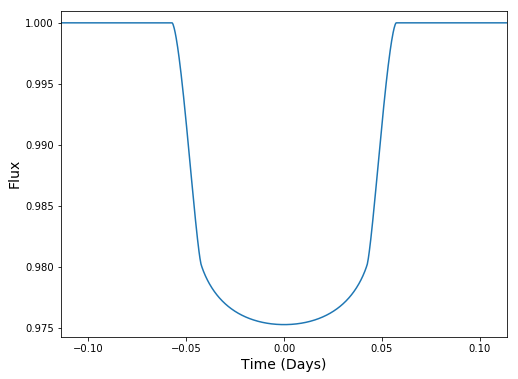

In [6]:
# Plot the light curve
plt.figure(figsize=(8,6))
plt.plot(times, flux)
plt.axis([times.min(), times.max(), flux.min()-.001, 1.001])
a=plt.ylabel("Flux",size=14)
a=plt.xlabel("Time (Days)",size=14)

In [7]:
# Add noise to the light curve
err   = 300.e-6  #300 ppm noise 
flux += np.random.normal(0, err, nint)

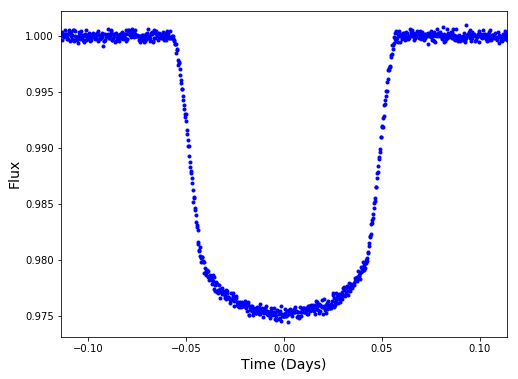

In [8]:
# Plot the new (noisy) light curve
plt.figure(figsize=(8,6))
plt.plot(times, flux, 'b.')
a=plt.xlim(times.min(), times.max())
a=plt.ylabel("Flux",size=14)
a=plt.xlabel("Time (Days)",size=14)

In [9]:
# Fit light curve model to the simulated data
result = lcmodel.fit(flux,                         # noisy data
                     weights     = 1/err,          # residuals = (data-model)*weights
                     params      = initialParams,  # Dependent parameters
                     times       = times,          # Independent paramter
                     ldtype      = 'quadratic',    # Independent paramter
                     transitType = 'primary',      # Independent paramter
                     method      = 'leastsq')      # Fitting method

In [10]:
# Print report
print(result.fit_report())

[[Model]]
    Model(batman_wrapper_lmfit)
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 900
    # variables        = 7
    chi-square         = 851.647
    reduced chi-square = 0.954
    Akaike info crit   = -35.700
    Bayesian info crit = -2.083
[[Variables]]
    rprs:        0.14715030 +/- 0.000291 (0.20%) (init= 0.147)
    period:      5.72149 (fixed)
    tcenter:     8.4955e-06 +/- 1.91e-05 (224.87%) (init= 0)
    inc:         89.6033229 +/- 0.111431 (0.12%) (init= 89.7)
    aprs:        18.1587144 +/- 0.066475 (0.37%) (init= 18.2)
    ecc:         0 (fixed)
    omega:       90 (fixed)
    u1:          0.28221744 +/- 0.015552 (5.51%) (init= 0.284)
    u2:          0.20393402 +/- 0.037363 (18.32%) (init= 0.208)
    offset:      0.99998484 +/- 1.38e-05 (0.00%) (init= 1)
    slope:       0 (fixed)
    curvature:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(inc, aprs)                 =  0.954 
    C(u1, u2)                    = -0

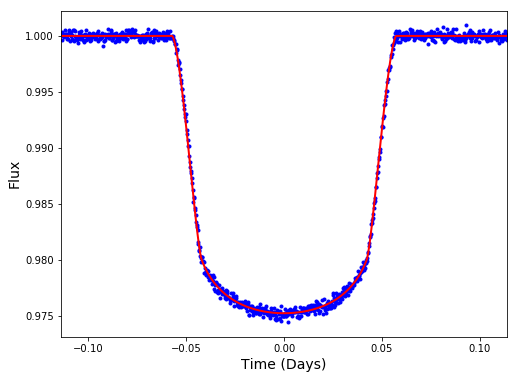

In [11]:
# Plot best-fit model overtop of simulated data
plt.figure(figsize=(8,6))
plt.plot(times, flux, 'b.')
plt.plot(times, result.best_fit, 'r-', lw=2)
a=plt.xlim(times.min(), times.max())
a=plt.ylabel("Flux",size=14)
a=plt.xlabel("Time (Days)",size=14)

### Now that we understand how BATMAN and LMFIT work, let's load in the time series of 1D spectra and get started!

In [12]:
# Load simulated 1D spectra
foo      = np.load("WASP107b-Spec1D.npz")
spec1D   = foo['spec1D']            # Time series of 1D spectra
times    = foo['times']             # Integration times in days
wave     = foo['wave']              # Wavelength solution in microns
err      = 3e-3                     # 3000 ppm uncertainty per point
# Get number of integrations and number of pixels
nint, nx = spec1D.shape
print(nint, nx)

900 1700


In [13]:
# Load limb-darkening coefficients
binwave, u1, u2 = np.loadtxt('WASP107_LDC.txt', skiprows=5, usecols=(0,1,3), unpack=True)
wave_low = binwave - np.ediff1d(binwave)[0]/2.
wave_hi  = binwave + np.ediff1d(binwave)[0]/2.
nchan    = len(binwave)                             # Number of spectrophotometric channels
npix     = int(nx/nchan)                            # Number of pixels per channel
res      = np.mean(binwave)/np.ediff1d(binwave)[0]  # Mean resolution
print(nchan, npix, res)

85 20 82.475


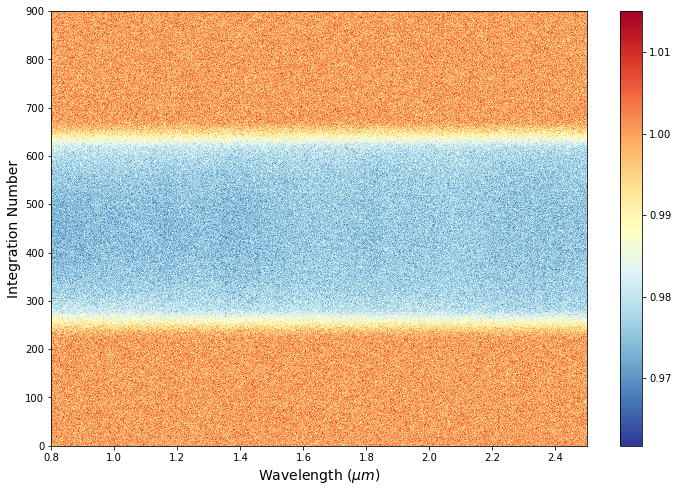

In [14]:
# Plot the time series of 1D spectra
# This may take a few seconds to complete
plt.figure(figsize=(12,8))
vmin        = spec1D.min()
vmax        = spec1D.max()
for j in range(nint):
    plt.scatter(wave, np.zeros(spec1D.shape[-1])+j, c=spec1D[j], 
                s=4,linewidths=0,vmin=vmin,vmax=vmax,marker='s',cmap=plt.cm.RdYlBu_r)
plt.xlim(wave[0],wave[-1])
plt.ylim(0,nint)
plt.ylabel('Integration Number', size=14)
plt.xlabel('Wavelength ($\mu m$)', size=14)
a=plt.colorbar()

In [15]:
# Bin 1D spectra into spectrophotometric channels
binflux = np.zeros((nchan,nint))
binerr  = np.zeros((nchan))
for i in range(nchan):
    index      = np.where((wave >= wave_low[i])*(wave <= wave_hi[i]))[0]
    binflux[i] = np.sum(spec1D[:,index],axis=1)
    binerr[i]  = np.sqrt(len(index))*err

In [16]:
# Fit BATMAN transit model to each spectrophotometric light curve
results = []
for i in range(nchan):
    # Set initial parameters using an ordered dictionary of Parameter objects
    initialParams = lmfit.Parameters()
    # Format: (key, value, vary?, min, max)
    initialParams.add_many(                     # WASP-107b paramters from Anderson et al (2017)
        ('rprs' , 0.147, True, 0.0, 0.2),       # Free parameter
        ('period' , 5.721490, False),
        ('tcenter' , 0., False),
        ('inc' , 89.7, False),
        ('aprs' , 18.2, False),
        ('ecc' , 0., False),
        ('omega' , 90., False),
        ('u1' , u1[i], False),                  # Linear LD coefficient 
        ('u2' , u2[i], False),                  # Quadratic LD coefficient
        ('offset', 1.0, True, 0.0),             # Free parameter
        ('slope', 0.0, False),     
        ('curvature', 0.0, False))
    # Initialize model
    lcmodel = lmfit.Model(batman_wrapper_lmfit, independent_vars = ['times', 'ldtype', 'transitType'])
    # Fit light curve model to the simulated data
    results.append(lcmodel.fit(binflux[i],                   # data
                               weights     = 1/binerr[i],    # residuals = (data-model)*weights
                               params      = initialParams,  # Dependent parameters
                               times       = times,          # Independent paramter
                               ldtype      = 'quadratic',    # Independent paramter
                               transitType = 'primary',      # Independent paramter
                               method      = 'leastsq'))     # Fitting method

In [17]:
# Print fit report for one of the channels
i = 30
print(results[i].fit_report())

[[Model]]
    Model(batman_wrapper_lmfit)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 900
    # variables        = 2
    chi-square         = 872.170
    reduced chi-square = 0.971
    Akaike info crit   = -24.269
    Bayesian info crit = -14.665
[[Variables]]
    rprs:        0.14835809 +/- 0.000144 (0.10%) (init= 0.147)
    period:      5.72149 (fixed)
    tcenter:     0 (fixed)
    inc:         89.7 (fixed)
    aprs:        18.2 (fixed)
    ecc:         0 (fixed)
    omega:       90 (fixed)
    u1:          0.292 (fixed)
    u2:          0.223 (fixed)
    offset:      19.9989491 +/- 0.000593 (0.00%) (init= 1)
    slope:       0 (fixed)
    curvature:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(rprs, offset)              =  0.660 



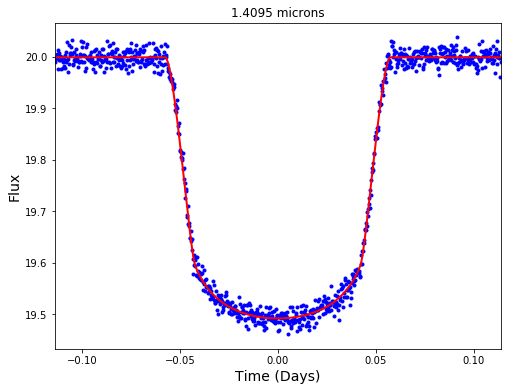

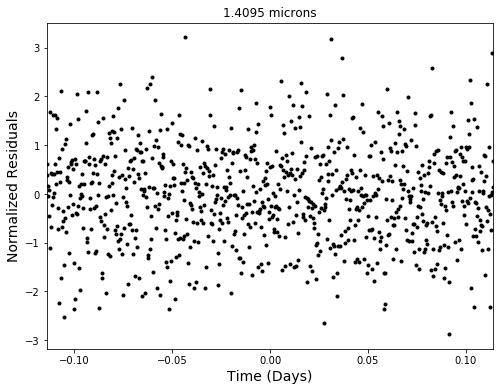

In [18]:
# Plot best fit light curve and residuals for the same channel
plt.figure(figsize=(8,6))
plt.title(str(binwave[i]) + " microns")
plt.plot(times, binflux[i], 'b.')
plt.plot(times, results[i].best_fit, 'r-', lw=2)
a=plt.xlim(times.min(), times.max())
plt.ylabel("Flux",size=14)
plt.xlabel("Time (Days)",size=14)
plt.figure(figsize=(8,6))
plt.title(str(binwave[i]) + " microns")
plt.plot(times, results[i].residual, 'k.')
a=plt.xlim(times.min(), times.max())
plt.ylabel("Normalized Residuals",size=14)
plt.xlabel("Time (Days)",size=14)

In [19]:
# Record best-fit radii and formal errors
rprs    = np.zeros(nchan)
rprserr = np.zeros(nchan)
for i in range(nchan):
    rprs[i]    = results[i].best_values['rprs']
    rprserr[i] = np.sqrt(results[i].covar[0,0])       # Assumes RpRs is 0th free parameter

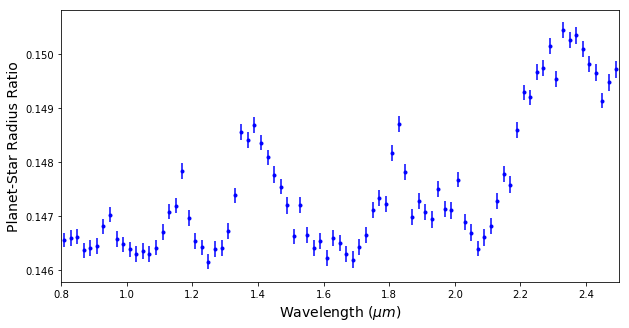

In [20]:
# Plot transmission spectrum
plt.figure(figsize=(10,5))
plt.errorbar(binwave, rprs, rprserr, fmt='b.')
plt.ylabel("Planet-Star Radius Ratio",size=14)
plt.xlabel("Wavelength ($\mu m$)",size=14)
a=plt.xlim(wave[0],wave[-1])

In [21]:
# Save results to file
np.savez("WASP107b-TranSpec.npz", binwave=binwave, rprs=rprs, rprserr=rprserr)